# Tutorial on self-normalizing networks on the MNIST data set: multi-layer perceptrons

*Author:* Kajetan Schweighofer, 2021

In [ ]:
import os
import copy
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# load data and preprocess

path = os.path.join(".", "dataset", "mnist")
os.makedirs(path, exist_ok=True)

# convert PIL image to tensor and normalize
transform = transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train = torchvision.datasets.MNIST(path, download=True, train=True, transform=transform)
test = torchvision.datasets.MNIST(path, download=True, train=False, transform=transform)

## Functions

### Model

In [ ]:

    
class ExpActivation(nn.Module):
    """
    Applies elementwise activation based on exponential function

    Inspired by squared relu, but with bounded range and gradient for better stability
    """
    def __init__(self):
        super(ExpActivation, self).__init__()

    def forward(self, input):
        # print("using exponential activation")
        return torch.exp(input)

class ReEUActivation(nn.Module):
    """
    Applies elementwise activation based on rectified exponential unit function
    f(x) = exp(x) if x > 0 else 0
    """
    def __init__(self):
        super(ReEUActivation, self).__init__()

    def forward(self, input):
        return torch.exp(nn.functional.relu(input)) - 1.0
    
    
class SoftmaxActivation(nn.Module):
    """
    Applies the Softmax activation function elementwise
    """
    def __init__(self):
        super(SoftmaxActivation, self).__init__()

    def forward(self, input):
        return nn.functional.softmax(input, dim=-1)
    
    

In [ ]:
class MLP(nn.Module):

    def __init__(self, in_features: int, out_features: int, p_drop=0.2, act_fn: str="relu"):
        super(MLP, self).__init__()

        if act_fn == "selu":
            activation = nn.SELU()
        elif act_fn == "relu":
            activation = nn.ReLU()
        elif act_fn == "exp":
            activation = ExpActivation()
        elif act_fn == "softmax":
            activation = SoftmaxActivation()
        elif act_fn == "reu":
            activation = ReEUActivation()
        elif act_fn == "elu":
            activation = nn.ELU()
        else:
            raise ValueError(f"Unsupported activation function: {act_fn}")
        # activation = nn.SELU() if act_fn == "selu" else nn.ReLU()
        # dropout = nn.AlphaDropout(p=p_drop) if act_fn == "selu" else nn.Dropout(p=p_drop) # use standard dropout for all activations
        dropout = nn.Dropout(p=p_drop)
        self.net = nn.Sequential(
            nn.Flatten(),   # flatten input image from batchx1x28x28 to batchx784
            nn.Linear(in_features=in_features, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=out_features)
        )

        if act_fn == "selu":
            for param in self.net.parameters():
                # biases zero
                if len(param.shape) == 1:
                    nn.init.constant_(param, 0)
                # others using lecun-normal initialization
                else:
                    nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        return self.net(x)

### Accuracy metric

In [ ]:
class Accuracy(nn.Module):

    def forward(self, x, y):

        y_pred = F.softmax(x, dim=1).argmax(dim=1).cpu().numpy()
        y = y.cpu().numpy()

        return accuracy_score(y_true=y, y_pred=y_pred)

### Training / Evaluation methods

In [ ]:
def _forward(network: nn.Module, data: DataLoader, metric: callable):

    for x, y in data:
        x = x.to(next(network.parameters()).device)

        # y_hat = network.forward(x)
        y_hat = network.forward(x).cpu()
        loss = metric(y_hat, y)
        yield loss

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: torch.optim.Optimizer) -> list:

    network.train()

    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        opt.zero_grad()
        try:
            err.backward()
            opt.step()
        except:
            print('error in update step')
    return errs

@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> float:

    network.eval()

    performance = []
    for p in _forward(network, data, metric):
        p = np.array(p)
        performance.append(p.item())
    return np.mean(performance).item()


def fit(network: nn.Module, trainloader: DataLoader, valloader: DataLoader,
          testloader: DataLoader, epochs: int, lr: float):
    optimizer = torch.optim.SGD(params=network.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    accuracy = Accuracy()

    train_losses, val_losses, accuracies = [], [], []

    # performance before training
    val_losses.append(evaluate(network=network, data=valloader, metric=ce))

    pbar = tqdm(range(epochs))
    for ep in pbar:
        # update network
        tl = update(network=network, data=trainloader, loss=ce, opt=optimizer)
        train_losses.extend(tl)
        vl = evaluate(network=network, data=valloader, metric=ce)
        val_losses.append(vl)
        ac = evaluate(network=network, data=valloader, metric=accuracy)

        if len(accuracies) == 0 or ac > max(accuracies):
            # here we would store the model on disc for early stopping
            best_model = copy.deepcopy(network)

        accuracies.append(ac)

        print(f"train loss: {round(np.mean(tl), 4):.4f}, "
              f"val loss: {round(vl, 4):.4f}, "
              f"accuracy: {round(ac * 100, 2):.2f}%")

        pbar.set_description_str(desc=f"Epoch {ep+1}")

    # evaluate on best model obtained throughout training
    acc = evaluate(network=best_model, data=testloader, metric=accuracy)

    print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

    return train_losses, val_losses, accuracies, acc

## Training

### Hyperparameters

In [ ]:
epochs = 20
lr = 1e-3
batch_size = 128
num_workers = 4
p_drop = 0.05

### Create Dataloaders

In [ ]:
# obtain validation set (1/6 of train data to be equal to size of test data)
rng = np.random.default_rng(seed=42)
val_inds = rng.choice(np.arange(len(train)), size=len(train)//6, replace=False)
train_inds = np.delete(np.arange(len(train)), val_inds)

trainloader = DataLoader(Subset(train, indices=train_inds),
                         batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
valloader = DataLoader(Subset(train, indices=val_inds),
                       batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
testloader = DataLoader(test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

### Train Networks

In [ ]:
# ReLU training

# 28x28 = 784 input images for 10 classes
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="relu").to(device)
rtl, rvl, raccs, racc = fit(network, trainloader, valloader, testloader, epochs, lr)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1:   5%|▌         | 1/20 [01:23<26:21, 83.22s/it]

train loss: 2.3014, val loss: 2.2988, accuracy: 11.46%


Epoch 2:  10%|█         | 2/20 [02:47<25:05, 83.62s/it]

train loss: 2.2972, val loss: 2.2941, accuracy: 13.47%


Epoch 3:  15%|█▌        | 3/20 [04:23<25:16, 89.22s/it]

train loss: 2.2926, val loss: 2.2888, accuracy: 18.77%


Epoch 4:  20%|██        | 4/20 [05:50<23:36, 88.50s/it]

train loss: 2.2871, val loss: 2.2825, accuracy: 24.93%


Epoch 5:  25%|██▌       | 5/20 [07:19<22:09, 88.65s/it]

train loss: 2.2804, val loss: 2.2745, accuracy: 29.95%


Epoch 6:  30%|███       | 6/20 [08:43<20:20, 87.20s/it]

train loss: 2.2719, val loss: 2.2643, accuracy: 33.49%


Epoch 7:  35%|███▌      | 7/20 [10:08<18:43, 86.39s/it]

train loss: 2.2608, val loss: 2.2506, accuracy: 32.38%


Epoch 8:  40%|████      | 8/20 [11:34<17:16, 86.39s/it]

train loss: 2.2454, val loss: 2.2314, accuracy: 33.21%


Epoch 9:  45%|████▌     | 9/20 [12:57<15:38, 85.30s/it]

train loss: 2.2236, val loss: 2.2037, accuracy: 36.57%


Epoch 10:  50%|█████     | 10/20 [14:18<13:58, 83.88s/it]

train loss: 2.1916, val loss: 2.1632, accuracy: 38.58%


Epoch 11:  55%|█████▌    | 11/20 [15:33<12:09, 81.10s/it]

train loss: 2.1444, val loss: 2.1041, accuracy: 39.22%


Epoch 12:  60%|██████    | 12/20 [16:55<10:52, 81.50s/it]

train loss: 2.0772, val loss: 2.0229, accuracy: 40.86%


Epoch 13:  65%|██████▌   | 13/20 [18:19<09:34, 82.11s/it]

train loss: 1.9847, val loss: 1.9128, accuracy: 45.08%


Epoch 14:  70%|███████   | 14/20 [19:39<08:09, 81.56s/it]

train loss: 1.8564, val loss: 1.7590, accuracy: 51.78%


Epoch 15:  75%|███████▌  | 15/20 [20:58<06:43, 80.73s/it]

train loss: 1.6812, val loss: 1.5586, accuracy: 59.63%


Epoch 16:  80%|████████  | 16/20 [22:27<05:33, 83.28s/it]

train loss: 1.4702, val loss: 1.3418, accuracy: 66.70%


Epoch 17:  85%|████████▌ | 17/20 [23:47<04:06, 82.17s/it]

train loss: 1.2698, val loss: 1.1530, accuracy: 72.58%


Epoch 18:  90%|█████████ | 18/20 [25:04<02:41, 80.89s/it]

train loss: 1.1032, val loss: 0.9983, accuracy: 75.33%


Epoch 19:  95%|█████████▌| 19/20 [26:25<01:20, 80.80s/it]

train loss: 0.9652, val loss: 0.8722, accuracy: 77.77%


Epoch 20: 100%|██████████| 20/20 [27:46<00:00, 83.33s/it]

train loss: 0.8548, val loss: 0.7735, accuracy: 79.70%


Final accuracy on testset: 80.11%


In [ ]:
# SELU training
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="selu").to(device)
stl, svl, saccs, sacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [01:18<24:53, 78.60s/it]

train loss: 0.9354, val loss: 0.5236, accuracy: 84.78%


Epoch 2:  10%|█         | 2/20 [02:41<24:19, 81.07s/it]

train loss: 0.5132, val loss: 0.4148, accuracy: 87.69%


Epoch 3:  15%|█▌        | 3/20 [04:02<23:00, 81.21s/it]

train loss: 0.4338, val loss: 0.3707, accuracy: 88.92%


Epoch 4:  20%|██        | 4/20 [05:26<21:53, 82.11s/it]

train loss: 0.3910, val loss: 0.3413, accuracy: 89.84%


Epoch 5:  25%|██▌       | 5/20 [06:47<20:29, 81.94s/it]

train loss: 0.3636, val loss: 0.3233, accuracy: 90.18%


Epoch 6:  30%|███       | 6/20 [08:12<19:22, 83.00s/it]

train loss: 0.3437, val loss: 0.3095, accuracy: 90.70%


Epoch 7:  35%|███▌      | 7/20 [10:45<22:56, 105.86s/it]

train loss: 0.3285, val loss: 0.2980, accuracy: 91.13%


Epoch 8:  40%|████      | 8/20 [13:21<24:19, 121.63s/it]

train loss: 0.3163, val loss: 0.2871, accuracy: 91.41%


Epoch 9:  45%|████▌     | 9/20 [15:59<24:22, 133.00s/it]

train loss: 0.3051, val loss: 0.2797, accuracy: 91.54%


Epoch 10:  50%|█████     | 10/20 [18:30<23:07, 138.78s/it]

train loss: 0.2966, val loss: 0.2730, accuracy: 91.73%


Epoch 11:  55%|█████▌    | 11/20 [21:02<21:25, 142.82s/it]

train loss: 0.2872, val loss: 0.2664, accuracy: 92.01%


Epoch 12:  60%|██████    | 12/20 [22:06<15:50, 118.75s/it]

train loss: 0.2802, val loss: 0.2599, accuracy: 92.33%


Epoch 13:  65%|██████▌   | 13/20 [23:28<12:32, 107.52s/it]

train loss: 0.2740, val loss: 0.2539, accuracy: 92.50%


Epoch 14:  70%|███████   | 14/20 [26:01<12:07, 121.26s/it]

train loss: 0.2663, val loss: 0.2499, accuracy: 92.59%


Epoch 15:  75%|███████▌  | 15/20 [28:33<10:52, 130.47s/it]

train loss: 0.2599, val loss: 0.2450, accuracy: 92.70%


Epoch 16:  80%|████████  | 16/20 [31:05<09:08, 137.10s/it]

train loss: 0.2562, val loss: 0.2410, accuracy: 92.84%


Epoch 17:  85%|████████▌ | 17/20 [33:54<07:19, 146.51s/it]

train loss: 0.2513, val loss: 0.2365, accuracy: 92.96%


Epoch 18:  90%|█████████ | 18/20 [37:38<05:40, 170.07s/it]

train loss: 0.2445, val loss: 0.2327, accuracy: 93.05%


Epoch 19:  95%|█████████▌| 19/20 [41:24<03:06, 186.74s/it]

train loss: 0.2391, val loss: 0.2290, accuracy: 93.22%


Epoch 20: 100%|██████████| 20/20 [45:06<00:00, 135.33s/it]

train loss: 0.2366, val loss: 0.2248, accuracy: 93.27%


Final accuracy on testset: 93.84%


In [ ]:
# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="exp").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu").to(device)

softtl, softvl, softaccs, softacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [03:56<1:14:53, 236.51s/it]

train loss: nan, val loss: nan, accuracy: 9.97%


Epoch 2:  10%|█         | 2/20 [07:51<1:10:37, 235.44s/it]

train loss: nan, val loss: nan, accuracy: 9.97%


Epoch 3:  15%|█▌        | 3/20 [11:48<1:07:00, 236.52s/it]

train loss: nan, val loss: nan, accuracy: 9.99%


Epoch 4:  20%|██        | 4/20 [15:34<1:01:54, 232.13s/it]

train loss: nan, val loss: nan, accuracy: 10.00%


Epoch 5:  25%|██▌       | 5/20 [19:19<57:21, 229.42s/it]  

train loss: nan, val loss: nan, accuracy: 9.97%


Epoch 6:  30%|███       | 6/20 [22:38<51:07, 219.11s/it]

train loss: nan, val loss: nan, accuracy: 9.98%


Epoch 7:  35%|███▌      | 7/20 [25:16<43:08, 199.10s/it]

train loss: nan, val loss: nan, accuracy: 9.99%


Epoch 8:  40%|████      | 8/20 [27:54<37:12, 186.01s/it]

train loss: nan, val loss: nan, accuracy: 9.99%


Epoch 9:  45%|████▌     | 9/20 [30:38<32:50, 179.16s/it]

train loss: nan, val loss: nan, accuracy: 9.99%


Epoch 10:  50%|█████     | 10/20 [33:28<29:25, 176.55s/it]

train loss: nan, val loss: nan, accuracy: 9.98%


Epoch 11:  55%|█████▌    | 11/20 [36:10<25:48, 172.01s/it]

train loss: nan, val loss: nan, accuracy: 9.98%


Epoch 12:  60%|██████    | 12/20 [38:45<22:13, 166.74s/it]

train loss: nan, val loss: nan, accuracy: 9.97%


Epoch 13:  65%|██████▌   | 13/20 [40:31<17:18, 148.37s/it]

train loss: nan, val loss: nan, accuracy: 9.97%


Epoch 14:  70%|███████   | 14/20 [41:39<12:24, 124.04s/it]

train loss: nan, val loss: nan, accuracy: 9.98%


Epoch 15:  75%|███████▌  | 15/20 [43:00<09:16, 111.30s/it]

train loss: nan, val loss: nan, accuracy: 9.99%


Epoch 16:  80%|████████  | 16/20 [43:57<06:19, 94.81s/it] 

train loss: nan, val loss: nan, accuracy: 9.98%


Epoch 17:  85%|████████▌ | 17/20 [44:11<03:31, 70.54s/it]

train loss: nan, val loss: nan, accuracy: 9.99%


Epoch 18:  90%|█████████ | 18/20 [45:20<02:19, 69.95s/it]

train loss: nan, val loss: nan, accuracy: 9.97%


Epoch 19:  95%|█████████▌| 19/20 [46:45<01:14, 74.66s/it]

train loss: nan, val loss: nan, accuracy: 9.99%


Epoch 20: 100%|██████████| 20/20 [48:07<00:00, 144.38s/it]

train loss: nan, val loss: nan, accuracy: 9.99%


Final accuracy on testset: 9.76%


In [ ]:
# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="elu").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu").to(device)

elutl, eluvl, eluaccs, eluacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [01:20<25:35, 80.81s/it]

train loss: 2.2482, val loss: 2.1988, accuracy: 54.50%


Epoch 2:  10%|█         | 2/20 [02:40<24:03, 80.21s/it]

train loss: 2.1432, val loss: 2.0773, accuracy: 67.01%


Epoch 3:  15%|█▌        | 3/20 [03:55<22:03, 77.88s/it]

train loss: 1.9966, val loss: 1.8991, accuracy: 66.99%


Epoch 4:  20%|██        | 4/20 [05:13<20:42, 77.66s/it]

train loss: 1.7842, val loss: 1.6525, accuracy: 66.01%


Epoch 5:  25%|██▌       | 5/20 [06:34<19:43, 78.93s/it]

train loss: 1.5211, val loss: 1.3837, accuracy: 67.83%


Epoch 6:  30%|███       | 6/20 [07:52<18:20, 78.62s/it]

train loss: 1.2674, val loss: 1.1488, accuracy: 71.59%


Epoch 7:  35%|███▌      | 7/20 [09:07<16:48, 77.56s/it]

train loss: 1.0603, val loss: 0.9691, accuracy: 74.93%


Epoch 8:  40%|████      | 8/20 [10:26<15:35, 77.99s/it]

train loss: 0.9064, val loss: 0.8383, accuracy: 78.17%


Epoch 9:  45%|████▌     | 9/20 [11:43<14:15, 77.74s/it]

train loss: 0.7957, val loss: 0.7441, accuracy: 80.83%


Epoch 10:  50%|█████     | 10/20 [12:59<12:50, 77.08s/it]

train loss: 0.7147, val loss: 0.6738, accuracy: 82.41%


Epoch 11:  55%|█████▌    | 11/20 [14:12<11:22, 75.80s/it]

train loss: 0.6527, val loss: 0.6197, accuracy: 83.47%


Epoch 12:  60%|██████    | 12/20 [15:28<10:07, 75.99s/it]

train loss: 0.6041, val loss: 0.5763, accuracy: 84.31%


Epoch 13:  65%|██████▌   | 13/20 [16:44<08:51, 75.92s/it]

train loss: 0.5655, val loss: 0.5415, accuracy: 85.14%


Epoch 14:  70%|███████   | 14/20 [17:55<07:27, 74.56s/it]

train loss: 0.5340, val loss: 0.5126, accuracy: 85.81%


Epoch 15:  75%|███████▌  | 15/20 [19:12<06:15, 75.14s/it]

train loss: 0.5063, val loss: 0.4886, accuracy: 86.63%


Epoch 16:  80%|████████  | 16/20 [20:24<04:57, 74.29s/it]

train loss: 0.4838, val loss: 0.4680, accuracy: 87.12%


Epoch 17:  85%|████████▌ | 17/20 [20:38<02:47, 55.99s/it]

train loss: 0.4639, val loss: 0.4496, accuracy: 87.63%


Epoch 18:  90%|█████████ | 18/20 [21:23<01:45, 52.95s/it]

train loss: 0.4476, val loss: 0.4348, accuracy: 88.03%


Epoch 19:  95%|█████████▌| 19/20 [22:34<00:58, 58.39s/it]

train loss: 0.4322, val loss: 0.4212, accuracy: 88.28%


Epoch 20: 100%|██████████| 20/20 [23:51<00:00, 71.55s/it]

train loss: 0.4189, val loss: 0.4098, accuracy: 88.58%


Final accuracy on testset: 88.71%


### Plot results

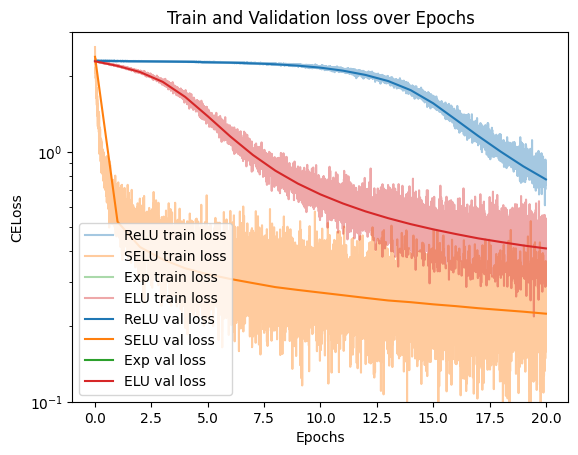

In [ ]:
plt.figure()
plt.plot(np.asarray(range(len(rtl))) / len(trainloader), rtl, alpha=0.4, label="ReLU train loss")
plt.plot(np.asarray(range(len(stl))) / len(trainloader), stl, alpha=0.4, label="SELU train loss")
plt.plot(np.asarray(range(len(softtl))) / len(trainloader), softtl, alpha=0.4, label="Exp train loss")
plt.plot(np.asarray(range(len(elutl))) / len(trainloader), elutl, alpha=0.4, label="ELU train loss")
plt.plot(range(len(rvl)), rvl, color="C0", label="ReLU val loss")
plt.plot(range(len(svl)), svl, color="C1", label="SELU val loss")
plt.plot(range(len(softvl)), softvl, color="C2", label="Exp val loss")
plt.plot(range(len(eluvl)), eluvl, color="C3", label="ELU val loss")
plt.title("Train and Validation loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("CELoss")
plt.ylim(1e-1, 3)
plt.yscale("log")
plt.legend()
plt.show()

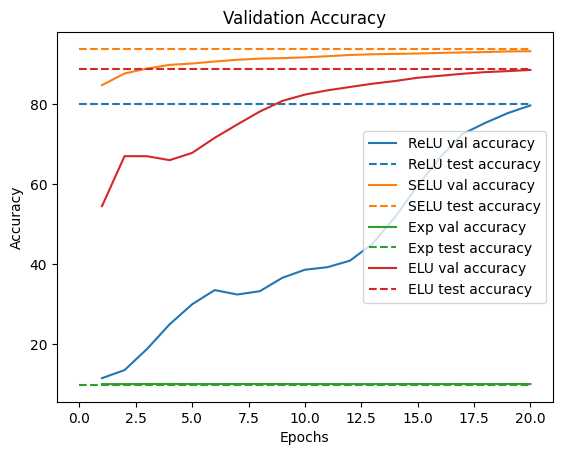

In [ ]:
plt.figure()
plt.plot(range(1, len(raccs)+1), [a*100 for a in raccs], label="ReLU val accuracy")
plt.hlines(y=racc*100, xmin=0, xmax=len(raccs), colors="C0", linestyles="dashed", label="ReLU test accuracy")
plt.plot(range(1, len(saccs)+1), [a*100 for a in saccs], label="SELU val accuracy")
plt.hlines(y=sacc*100, xmin=0, xmax=len(saccs), colors="C1", linestyles="dashed", label="SELU test accuracy")
plt.plot(range(1, len(softaccs)+1), [a*100 for a in softaccs], label="Exp val accuracy")
plt.hlines(y=softacc*100, xmin=0, xmax=len(softaccs), colors="C2", linestyles="dashed", label="Exp test accuracy")
plt.plot(range(1, len(eluaccs)+1), [a*100 for a in eluaccs], label="ELU val accuracy")
plt.hlines(y=eluacc*100, xmin=0, xmax=len(eluaccs), colors="C3", linestyles="dashed", label="ELU test accuracy")

plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()